## Correlation Power Analysis (CPA) Project

Correlation Power Analysis (CPA) is a variat of side channel analysis that collects many power traces while the device under test (DUT) is performing a cryptographic operating. The attacker select an attack piont to where an intermediate value is calculated in the device. The intermeadiate value should be a function of known data (e.g plaintext) and a small portion of the key.
The attacker use all possible values of the key portion to calculate the possible values of the intermediate. A power model (Hamming weight or distance) is used to calculated values propotional to the power consumtion of the device while u=it calculates the intermediate. These values are called the hypothetical power.
The real power traces collected is then statistically correlated with hypothetical power to find the key most likley used in the crypto operation.


In this project, you will apply CPA on a AES-128 FPGA implementation (DUT). A setup is provided to send test vectors to the DUT, collect the traces for you using a power probe and ADC. Later in the project, you will take the traces and run the CPA analysis software to find the secret key used in the algorithm.

Step 2: Power measurement
-------------------------
Measure the power consumption of the  crypto device while it encrypts/decrypts D data blocks.
We need to know the value *d* the corresponds to each data block. These values can be written as a vector **d** = [d\ :sub:`1`, d\ :sub:`2`, ..., d\ :sub:`D`].
The power consumption signal for a single encryption/decryption operation is called a trace.
A trace is vector that records instantaneous power consumption for the time of interest (the time when the intermediate value is being processed).
The trace generated while encrypting/decrypting data block *i* consists of *T* samples and can be viewed as a vector **t**\ :sub:`i` = [t\ :sub:`i,1`, t\ :sub:`i,2`,... , t\ :sub:`i,T`].
The traces are stacked in a matrix **T** with dimensions *D x T* where each row i is a trace generated while encrypting/decrypting block *i*.


In [135]:
import os
import shutil
import fobos.pynqctrl
from fobos.fobosctrl import FOBOSCtrl
import fobos.projmgr
import fobos.nexys3dut
import numpy as np

In [136]:
WORKSPACE = "./fobosworkspace"
PROJECT_NAME = "aes"
DIN_FILE_NAME = "dinFile.txt"
CIPHER_FILE = "ciphertext.txt"
TRACE_FILE  = "powerTraces.npy"
DUT_BIT_FILE = "half_duplex_dut.bit"

In [137]:
TRACE_NUM = 1000
DUT_CLk = 1
OUT_LEN = 16
SAMPLING_FREQ = 50
ADC_GAIN = 20
SAMPLES_PER_TRACE = 1000

In [138]:
# Instantiate FOBOS objects###########################################
ctrl = fobos.pynqctrl.PYNQCtrl(IP, PORT)

Acquired hardware lock


In [139]:
ctrl.setDUTClk(DUT_CLk)
ctrl.setDUTInterface(FOBOSCtrl.INTERFACE_4BIT)
ctrl.setOutLen(OUT_LEN)
ctrl.setTriggerMode(FOBOSCtrl.TRG_FULL)
###configure trace sampling
ctrl.setSamplingFrequency(SAMPLING_FREQ)
ctrl.setADCGain(ADC_GAIN)
ctrl.setSamplesPerTrace(SAMPLES_PER_TRACE)
# Configure project directories#########################################
pm = fobos.projmgr.ProjectManager()
pm.setWorkSpaceDir(WORKSPACE)
pm.setProjName(PROJECT_NAME)
projDir = pm.getProjDir()
# program DUT ##########################################################
dut = fobos.nexys3dut.Nexys3DUT()
bitFile = os.path.join(projDir, DUT_BIT_FILE)
dut.setBitFile(bitFile)
dut.program()
# prepare i/o files ####################################################
tvFileName = os.path.join(projDir, DIN_FILE_NAME)
tvFile = open(tvFileName, "r")
captureDir = pm.getCaptureDir()
cipherFileName = os.path.join(captureDir, CIPHER_FILE)
cipherFile = open(cipherFileName, "w")
traceFileName = os.path.join(captureDir, TRACE_FILE)
traceFile = open(traceFileName, "a+b")
shutil.copy(tvFileName, captureDir)
# Get traces############################################################
print('Processing test vectors ...')
traceNum = 0
while traceNum < TRACE_NUM:
    data = tvFile.readline()
    status, result, trace = ctrl.processData2(data, OUT_LEN)
    # if status != fobos.OK:
    #     print("TIMEOUT")
    cipherFile.write(result + "\n")
    np.save(traceFile, trace)
    traceNum += 1
print("Done!")

outlen=16
Programming device using the following commands:
djtgcfg init -d Nexys3
djtgcfg prog -d Nexys3 -i 0 -f ./fobosworkspace/aes/half_duplex_dut.bit
b'Programming device. Do not touch your board. This may take a few minutes...\nProgramming succeeded.\n'
Successfully created new capture directory at ./fobosworkspace/aes/capture/attempt-5
Processing test vectors ...
Done!


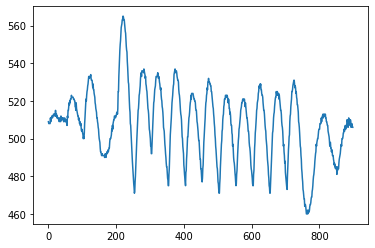

In [133]:
import matplotlib.pyplot as plt
traceFile.seek(0)
trace = np.load(traceFile)
plt.plot(trace[0:900])

In [134]:
ctrl.disconnect()
tvFile.close()
cipherFile.close()
traceFile.close()

Disconnect requested. Bye!
Released hardware lock.
